In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from glob import glob
import pandas as pd
import numpy as np
import os
import re

# Leer datos Indices de Rezago Social

In [2]:
folders_IRS = os.listdir("data/")
folders_IRS = ["data/"+i for i in folders_IRS if "IRS" in i]
folders_IRS

['data/IRS_localidades_2000.xlsx',
 'data/IRS_localidades_2005.xlsx',
 'data/IRS_localidades_2010.xlsx',
 'data/IRS_localidades_2020.xlsx']

In [3]:
rename_columns = {
    "Indicadores de rezago social (porcentaje)":np.NaN,
    "Entidad \nfederativa":"Entidad federativa",
    "Población \ntotal":"Población total",
}

In [4]:
def loadISR(folders_IRS):
    ISR_full = pd.DataFrame()
    colnames = []

    for folder in folders_IRS:
        ISR_df = pd.ExcelFile(folder)
        year = folder[:-5].split("_")[-1]
        for sheet in ISR_df.sheet_names:
            ISR_sheet = ISR_df.parse(sheet, skiprows=4)
            ISR_sheet.replace(rename_columns, inplace=True)
            ISR_sheet[:2] = ISR_sheet[:2].fillna(method="bfill")

            ISR_sheet.columns = ISR_sheet.iloc[0]
            ISR_sheet.drop(ISR_sheet.index[0], inplace=True)
            ISR_sheet.dropna(subset="Localidad", inplace=True)
            ISR_sheet.dropna(how="all", axis=1, inplace=True)
            ISR_sheet["year"] = year

            ISR_full = pd.concat([ISR_full, ISR_sheet], ignore_index=True)
            colnames.append(ISR_sheet.columns)

    return ISR_full
#ISR_full = loadISR(folders_IRS)
#ISR_full.to_csv("data/ISR_full.csv",index=False)
ISR_full = pd.read_csv("data/ISR_full.csv")
ISR_full["Entidad federativa"] = [i.lower().title() for i in ISR_full["Entidad federativa"]]

ISR_full["Entidad federativa"].replace({
    "Varacruz De Ignacio De La Llave":"Veracruz De Ignacio De La Llave",
    "Distrito Federal":"Ciudad De México",
    "Querétaro":"Querétaro De Arteaga"}, inplace=True)

# Datos DAYMET

In [5]:
daymet_root = "data/daymet/"
list_daymet = os.listdir(daymet_root)
list_daymet = [daymet_root+i for i in list_daymet]
print(len(list_daymet))
list_daymet[:5]

7665


['data/daymet/2000-01-01.csv',
 'data/daymet/2000-01-02.csv',
 'data/daymet/2000-01-03.csv',
 'data/daymet/2000-01-04.csv',
 'data/daymet/2000-01-05.csv']

In [6]:
def read_daymet(dirs):
    df_final = pd.DataFrame(columns=[
        "dayl","prcp","srad","swe","tmax","tmin","vp", 'NOMGEO', 'CVE_ENT', 'date'
    ])
    for dir in dirs:
        df = pd.read_csv(dir)
        date = dir[12:-4]
        df["date"] = date

        df.drop(columns=["CVEGEO", "system:index"],
                inplace=True)

        df_final = pd.concat([df_final, df])

    df_final["date"] = pd.to_datetime(df_final["date"],
                                      infer_datetime_format=True)
    df_final["week_index"] = df_final.date.dt.week
    df_final["year"] = df_final.date.dt.year
    df_final = df_final.groupby(by=["NOMGEO", "year", "week_index"],
                                as_index=False).mean()
    df_final.rename(columns={"NOMGEO":"estado"}, inplace=True)

    return df_final

#df_daymet = read_daymet(list_daymet)
#df_daymet.to_csv("data/daymet_full.csv",index=False)
df_daymet = pd.read_csv("data/daymet_full.csv")
df_daymet

,estado,year,week_index,dayl,prcp,srad,swe,tmax,tmin,vp,CVE_ENT,date
0,Aguascalientes,2000,1,38569.752366,0.00000,421.139878,0.0,22.647606,1.195663,302.881345,1.0,2000-01-06 00:00:00
1,Aguascalientes,2000,2,38785.064030,0.00000,412.376690,0.0,22.635875,2.480746,328.648852,1.0,2000-01-13 00:00:00
2,Aguascalientes,2000,3,39067.301995,0.00000,441.500852,0.0,22.363806,0.680293,249.668226,1.0,2000-01-20 00:00:00
3,Aguascalientes,2000,4,39409.100832,0.00000,456.997165,0.0,23.790566,1.858065,247.247024,1.0,2000-01-27 00:00:00
4,Aguascalientes,2000,5,39802.388079,0.00000,462.369302,0.0,22.275614,1.152001,234.512377,1.0,2000-02-03 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
35163,Zacatecas,2020,49,38281.518666,0.33643,383.272928,0.0,21.006084,2.734376,509.366442,32.0,2020-12-03 00:00:00
35164,Zacatecas,2020,50,38123.916678,0.00000,379.154386,0.0,22.240216,5.068265,381.561733,32.0,2020-12-10 00:00:00
35165,Zacatecas,2020,51,38048.463078,0.00000,410.478614,0.0,23.080537,3.146933,273.529405,32.0,2020-12-17 00:00:00
35166,Zacatecas,2020,52,38057.495608,0.00000,405.290976,0.0,22.002875,2.286106,259.768301,32.0,2020-12-24 00:00:00


# Leer datos dengue

In [9]:
dengue_sheets = pd.ExcelFile("data/dengue-climate.xlsx")

In [10]:
def groupdenguedata(sheets, excelfile):
    dfDengue = pd.DataFrame()

    for sheet in sheets:

        dfi = excelfile.parse(sheet, skiprows=2)
        dfi = dfi[dfi["id"] < 33]
        dfi.drop(columns=["id"], inplace=True)

        dfiMelted = dfi.melt(id_vars=["estado","year"], var_name="semana", value_name="casos")
        dfiMelted["year"] = dfiMelted["year"].astype(int)

        dfiMelted["clase"] = [re.split(pattern="_\d", string=i)[0] for i in dfiMelted["semana"]]
        dfiMelted["week"]  = [re.split(pattern="_", string=i)[-1] for i in dfiMelted["semana"]]

        dict_clases = {
            "clas":"Dengue clásico",
            "h_e":"Dengue hemorrágico (en estudio)",
            "h_c":"Dengue hemorrágico (confirmado)",
            " ":0,
            "-":0,
            "-----":0
        }
        dfiMelted.replace(dict_clases, inplace=True)

        dfiMelted["date"] = dfiMelted["year"].astype(str) + "-" +dfiMelted["week"]+"-1"
        dfiMelted["date"] = pd.to_datetime(dfiMelted["date"], format="%Y-%W-%w")


        dfDengue = pd.concat([dfDengue, dfiMelted])
    dfDengue["casos"].replace({
        "-":np.NaN,
        "n.e.":np.NaN,
        "n.e. ":np.NaN,
        "n.d ":np.NaN,
        "-----":np.NaN,
        " ":np.NaN,
        'n.e':np.NaN
        }, inplace=True)

    dfDengue["casos"].fillna(0, inplace=True)
    dfDengue["casos"] = dfDengue["casos"].astype(int)
    return dfDengue

In [11]:
#dfDengue = groupdenguedata(dengue_sheets.sheet_names, dengue_sheets)
#dfDengue.to_csv("dengue_full.csv", index=False)

dfDengue = pd.read_csv("data/dengue_full.csv")
print(dfDengue.columns)
dfDengue = dfDengue.pivot_table(values="casos", columns="clase", index=["estado","date"])
dfDengue.reset_index(inplace=True, drop=False)
dfDengue["date"] = pd.to_datetime(dfDengue["date"])
dfDengue["date"] = pd.DatetimeIndex(dfDengue.date) - pd.DateOffset(1)
dfDengue["year"] = dfDengue.date.dt.year
dfDengue["week_index"] =  dfDengue.date.dt.isocalendar().week
dfDengue

Index(['estado', 'year', 'semana', 'casos', 'clase', 'week', 'date'], dtype='object')


clase,estado,date,Dengue clásico,Dengue hemorrágico (confirmado),Dengue hemorrágico (en estudio),year,week_index
0,Aguascalientes,2002-01-06,0,0,0,2002,1
1,Aguascalientes,2002-01-13,0,0,0,2002,2
2,Aguascalientes,2002-01-20,0,0,0,2002,3
3,Aguascalientes,2002-01-27,0,0,0,2002,4
4,Aguascalientes,2002-02-03,0,0,0,2002,5
...,...,...,...,...,...,...,...
33275,Zacatecas,2021-11-28,0,0,0,2021,47
33276,Zacatecas,2021-12-05,0,0,0,2021,48
33277,Zacatecas,2021-12-12,0,0,0,2021,49
33278,Zacatecas,2021-12-19,0,0,0,2021,50


# Unir Daymet y Dengue

In [12]:
df = dfDengue.merge(df_daymet.drop(columns="date"), on=["estado","year","week_index"], how="inner")
df

,estado,date,Dengue clásico,Dengue hemorrágico (confirmado),Dengue hemorrágico (en estudio),year,week_index,dayl,prcp,srad,swe,tmax,tmin,vp,CVE_ENT
0,Aguascalientes,2002-01-06,0,0,0,2002,1,38490.104891,0.000000,412.658447,0.0,21.732162,1.271458,447.737208,1.0
1,Aguascalientes,2002-01-13,0,0,0,2002,2,38684.202857,4.695578,379.339061,0.0,20.654242,1.531907,443.580977,1.0
2,Aguascalientes,2002-01-20,0,0,0,2002,3,38938.597047,0.000000,424.981418,0.0,22.494717,2.036284,503.612944,1.0
3,Aguascalientes,2002-01-27,0,0,0,2002,4,39255.830578,0.000000,429.856307,0.0,23.342400,3.478972,480.582798,1.0
4,Aguascalientes,2002-02-03,0,0,0,2002,5,39628.063254,0.000000,447.646493,0.0,24.657705,4.532387,415.675041,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26671,Zacatecas,2020-11-29,0,0,0,2020,48,38516.551772,0.000000,378.852307,0.0,25.104916,7.252191,775.787390,32.0
26672,Zacatecas,2020-12-06,0,0,0,2020,49,38281.518666,0.336430,383.272928,0.0,21.006084,2.734376,509.366442,32.0
26673,Zacatecas,2020-12-13,0,0,0,2020,50,38123.916678,0.000000,379.154386,0.0,22.240216,5.068265,381.561733,32.0
26674,Zacatecas,2020-12-20,0,0,0,2020,51,38048.463078,0.000000,410.478614,0.0,23.080537,3.146933,273.529405,32.0


# Selección de estados con peor Indice de Rezago Social

In [13]:
metricas_IRS = {
    'Población total':"sum",
    'Población de 15 años o más analfabeta':"mean",
    'Población de 6 a 14 años que no asiste a la escuela':"mean",
    'Población de 15 años y más con educación básica incompleta':"mean",
    'Población sin derechohabiencia a servicios de salud':"mean",
    'Viviendas con piso de tierra':"mean",
    'Viviendas que no disponen de excusado o sanitario':"mean",
    'Viviendas que no disponen de agua entubada de la red pública':"mean",
    'Viviendas que no disponen de drenaje':"mean",
    'Viviendas que no disponen de energía eléctrica':"mean",
    'Viviendas que no disponen de lavadora':"mean",
    'Viviendas que no disponen de refrigerador':"mean",
    'Índice de rezago social':"mean",
    #'Grado de rezago social':"mean"
}
ISR_grouped = ISR_full.groupby(by=["Entidad federativa","year"],as_index=False).agg(metricas_IRS)
ISR_grouped

,Entidad federativa,year,Población total,Población de 15 años o más analfabeta,Población de 6 a 14 años que no asiste a la escuela,Población de 15 años y más con educación básica incompleta,Población sin derechohabiencia a servicios de salud,Viviendas con piso de tierra,Viviendas que no disponen de excusado o sanitario,Viviendas que no disponen de agua entubada de la red pública,Viviendas que no disponen de drenaje,Viviendas que no disponen de energía eléctrica,Viviendas que no disponen de lavadora,Viviendas que no disponen de refrigerador,Índice de rezago social
0,Aguascalientes,2000,936574,10.930003,11.195445,74.547689,62.373480,10.032481,35.605941,22.531630,40.995041,16.000521,50.150136,44.864418,-1.104847
1,Aguascalientes,2005,1058146,9.572598,6.815779,64.141214,29.914383,5.245232,21.341822,31.541837,24.173722,9.628286,35.275086,24.045499,-1.065121
2,Aguascalientes,2010,1177901,7.429436,4.884449,55.989686,22.018093,3.879390,13.630822,21.854259,16.540648,6.038195,31.257639,19.234665,-0.957932
3,Aguascalientes,2020,1418881,4.939935,5.311406,39.872213,22.493482,2.536156,5.051712,7.186626,7.212335,3.239929,20.631158,11.639619,-0.818566
4,Baja California,2000,2474721,8.562765,11.167313,65.057129,43.952923,12.583078,10.346601,47.863118,53.682698,19.754405,43.906391,27.814091,-1.359880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,Yucatán,2020,2315986,14.814792,5.018972,52.293401,18.091627,6.478154,22.497516,8.829993,25.613254,5.943169,47.145368,44.168513,-0.031026
124,Zacatecas,2000,1341477,12.926655,14.759248,84.391775,82.508268,18.830317,54.190491,49.639324,68.949119,19.465342,64.721109,52.872200,-0.450014
125,Zacatecas,2005,1356266,12.199800,9.804334,75.725834,74.626073,13.867611,36.083105,37.740486,40.520474,9.647877,47.342455,31.906858,-0.631761
126,Zacatecas,2010,1480822,9.777026,5.425653,66.357085,39.943610,7.777724,26.734361,33.414915,31.728471,7.171762,39.467370,25.098396,-0.553185


In [14]:
ISR_grouped = ISR_full.groupby(by=["Entidad federativa"]).agg(
    {"Índice de rezago social":"mean"})

ISR_grouped.sort_values("Índice de rezago social", ascending=False, inplace=True)
lista_ISR = ISR_grouped.iloc[:3]
lista_ISR = pd.concat([lista_ISR,ISR_grouped.iloc[-3:]])
lista_ISR

,Índice de rezago social
Entidad federativa,
Guerrero,0.730710
Chihuahua,0.581498
Chiapas,0.508659
Colima,-0.761249
Baja California,-0.932690
Aguascalientes,-0.978851


# Usar 5 estados con peor ISR

In [15]:
dfISR_worst = df[df["estado"].isin(lista_ISR.index)]
dfISR_worst

,estado,date,Dengue clásico,Dengue hemorrágico (confirmado),Dengue hemorrágico (en estudio),year,week_index,dayl,prcp,srad,swe,tmax,tmin,vp,CVE_ENT
0,Aguascalientes,2002-01-06,0,0,0,2002,1,38490.104891,0.000000,412.658447,0.0,21.732162,1.271458,447.737208,1.0
1,Aguascalientes,2002-01-13,0,0,0,2002,2,38684.202857,4.695578,379.339061,0.0,20.654242,1.531907,443.580977,1.0
2,Aguascalientes,2002-01-20,0,0,0,2002,3,38938.597047,0.000000,424.981418,0.0,22.494717,2.036284,503.612944,1.0
3,Aguascalientes,2002-01-27,0,0,0,2002,4,39255.830578,0.000000,429.856307,0.0,23.342400,3.478972,480.582798,1.0
4,Aguascalientes,2002-02-03,0,0,0,2002,5,39628.063254,0.000000,447.646493,0.0,24.657705,4.532387,415.675041,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9875,Guerrero,2020-11-29,1,4,3,2020,48,39741.314756,0.000000,400.371142,0.0,31.471129,14.032332,1536.045652,12.0
9876,Guerrero,2020-12-06,0,0,0,2020,49,39568.578964,0.000000,359.645349,0.0,29.744420,14.766156,1559.184803,12.0
9877,Guerrero,2020-12-13,0,1,7,2020,50,39452.819205,0.000000,365.160352,0.0,29.318730,14.296405,1436.702270,12.0
9878,Guerrero,2020-12-20,0,1,4,2020,51,39397.418184,0.000000,385.949258,0.0,29.732085,13.813803,1254.098073,12.0


In [30]:
dict_daymetcols = {
    "dayl":"Duration of the \ndaylight period",
    "prcp":"Daily total \nprecipitation",
    "srad":"Incident shortwave \nradiation flux density",
    "swe":"Snow water equivalent",
    "tmax":"Daily maximum \ntemperature.",
    "tmin":"Daily minimum \ntemperature",
    "vp":"Daily average partial \npressure of water vapor",
}

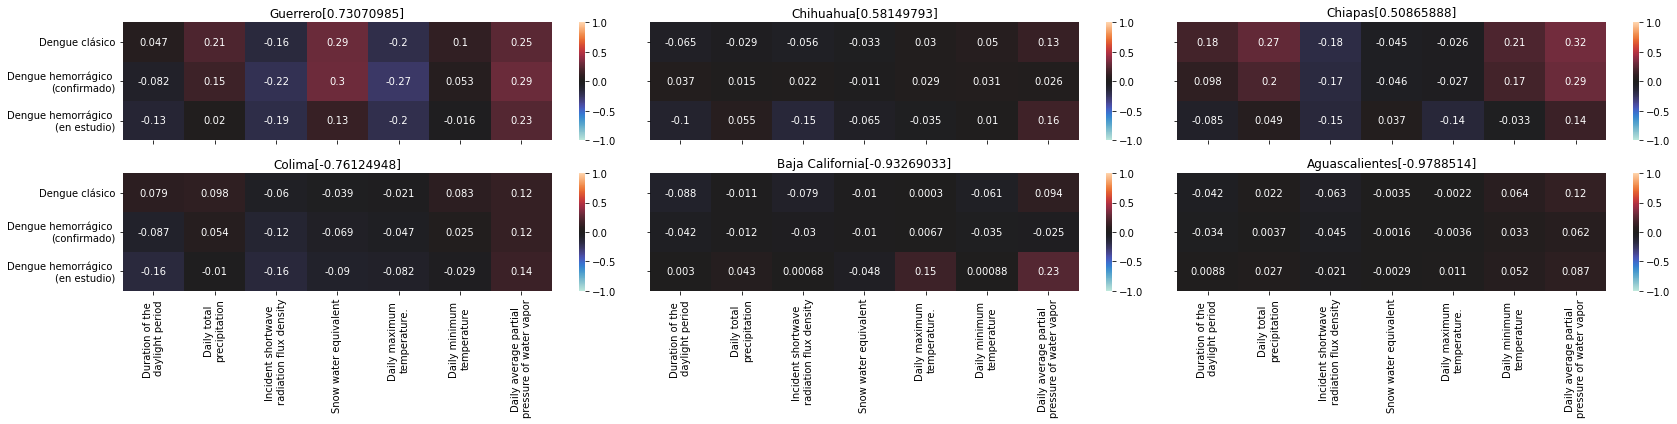

In [33]:
selected = ['Dengue clásico', 'Dengue hemorrágico \n(confirmado)',
       'Dengue hemorrágico \n(en estudio)','dayl', 'prcp',
       'srad', 'swe', 'tmax', 'tmin', 'vp']

rename_ISR_col = {
    "Dengue hemorrágico (confirmado)":"Dengue hemorrágico \n(confirmado)",
    "Dengue hemorrágico (en estudio)":"Dengue hemorrágico \n(en estudio)"}

nrows = 2
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24,6), sharey=True, sharex=True)

i = 0
for r in range(nrows):
    for c in range(ncols):
        state = lista_ISR.index[i]
        ISR_value = lista_ISR.values[i]

        df_i = dfISR_worst[dfISR_worst["estado"]==state].copy()

        df_i.rename(columns=rename_ISR_col, inplace=True)

        df_i = df_i[selected].corr().iloc[:3,3:]
        df_i.rename(columns=dict_daymetcols, inplace=True)
        sns.heatmap(df_i, ax=ax[r,c],annot=True, center=0, vmax=1, vmin=-1)

        ax[r,c].set(
            title = state + str(ISR_value)
        )

        i += 1

plt.tight_layout()
plt.show()

In [35]:
dfISR_worst

,estado,date,Dengue clásico,Dengue hemorrágico (confirmado),Dengue hemorrágico (en estudio),year,week_index,dayl,prcp,srad,swe,tmax,tmin,vp,CVE_ENT
0,Aguascalientes,2002-01-06,0,0,0,2002,1,38490.104891,0.000000,412.658447,0.0,21.732162,1.271458,447.737208,1.0
1,Aguascalientes,2002-01-13,0,0,0,2002,2,38684.202857,4.695578,379.339061,0.0,20.654242,1.531907,443.580977,1.0
2,Aguascalientes,2002-01-20,0,0,0,2002,3,38938.597047,0.000000,424.981418,0.0,22.494717,2.036284,503.612944,1.0
3,Aguascalientes,2002-01-27,0,0,0,2002,4,39255.830578,0.000000,429.856307,0.0,23.342400,3.478972,480.582798,1.0
4,Aguascalientes,2002-02-03,0,0,0,2002,5,39628.063254,0.000000,447.646493,0.0,24.657705,4.532387,415.675041,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9875,Guerrero,2020-11-29,1,4,3,2020,48,39741.314756,0.000000,400.371142,0.0,31.471129,14.032332,1536.045652,12.0
9876,Guerrero,2020-12-06,0,0,0,2020,49,39568.578964,0.000000,359.645349,0.0,29.744420,14.766156,1559.184803,12.0
9877,Guerrero,2020-12-13,0,1,7,2020,50,39452.819205,0.000000,365.160352,0.0,29.318730,14.296405,1436.702270,12.0
9878,Guerrero,2020-12-20,0,1,4,2020,51,39397.418184,0.000000,385.949258,0.0,29.732085,13.813803,1254.098073,12.0
